<a href="https://colab.research.google.com/github/MohammadParsaTheFirst/Deep-generative-models-course/blob/main/CHW3/DGM_HW3_GAN_Practical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Generative Models
</font>

<hr/>
<font color="#800080" size=5>
Assignment 3: Generative Adversarial Networks
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2024
<br>
</font>
<font face="Times New Roman" size=4>
Deadline: Month day at 23:55
</font>
<hr>
</div></font>

In [ ]:
name = 'MohammadParsa Dini'
std_id = '400101204'

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

if torch.cuda.is_available():
    torch.device = 'cuda'
else:
    torch.device = 'cpu'

device = torch.device
print(f'running on {device}')

running on cuda


### In this notebook, you will implement the required components from scratch, without code completion. Utilize `torch` to create models and perform optimization. The goal of this assignment is to implement Deep Convolutional Generative Adversarial Networks (DC-GAN) using the MNIST dataset and to explore interpolation in the latent space.

### To get started, please read the DC-GAN paper available at this link: [DC-GAN Paper](https://arxiv.org/abs/1511.06434v2).


### Part 1. Load the MNIST dataset.

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

IMAGE_SIZE = 28
CHANNELS_IMG = 1
BATCHSIZE = 64

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
    )
])

# trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
# testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=BATCHSIZE, shuffle=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:11<00:00, 891kB/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.69MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Part 2: Build the Generator and Discriminator models.
Build the models with the architecture guidelines for stable training as described in the paper. It is recommended to use the model parameters presented in `config.yaml`, but you are free to choose any set of parameters you prefer.


In [ ]:
import yaml
from pprint import pprint

file_path = 'config.yaml'

with open(file_path, 'r') as file :
    config = yaml.safe_load(file)

pprint(config)

{'model_params': {'discriminator_channels': [128, 256, 512],
                  'discriminator_kernels': [4, 4, 4, 4],
                  'discriminator_paddings': [1, 1, 1, 1],
                  'discriminator_strides': [2, 2, 2, 2],
                  'generator_channels': [512, 256, 128],
                  'generator_kernels': [4, 4, 4, 4],
                  'generator_output_paddings': [1, 1, 0, 0],
                  'generator_paddings': [1, 1, 1, 1],
                  'generator_strides': [2, 2, 2, 2],
                  'latent_dim': 100}}


In [3]:
import torch.nn as nn

LEAKY_RELU_SLOPE = 0.2
IMAGE_SIZE = 28
CHANNELS_IMG = 1
MEAN_GAUSSIAN = 0.0
STD_GAUSSIAN = 0.02

class Discriminator(nn.Module):
    def __init__(self, channels_image, feature_disc):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input : N x channels_image x 32 x 32
            nn.Conv2d(channels_image, feature_disc, kernel_size=4, padding=2, stride=1),           # 16 x 16
            nn.LeakyReLU(LEAKY_RELU_SLOPE),                                                        #
            self._block(feature_disc, feature_disc*2, kernel_size=4, stride=2, padding=1),         # 8 x 8
            self._block(feature_disc*2, feature_disc*4, kernel_size=4, stride=2, padding=1),       # 4 x 4
            nn.Conv2d(feature_disc*4, 1, kernel_size=4, stride=2, padding=1),                      # 1 x 1
            nn.Sigmoid(),                                                                          # 1 x 1
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(LEAKY_RELU_SLOPE)
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, z_dim, channels_image, feature_gen):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # N x features_gen x 1 x 1
            self._block(z_dim, feature_gen*8, kernel_size=4, stride=2, padding=1, output_padding=1),                    # N x features_gen x 4 x 4
            self._block(feature_gen*8, feature_gen*4, kernel_size=4, stride=2, padding=1, output_padding=1),            # 8 x 8
            self._block(feature_gen*4, feature_gen*2, kernel_size=4, stride=2, padding=1, output_padding=0),            # 16 x 16
            nn.ConvTranspose2d(feature_gen*2, channels_image, kernel_size=4, stride=2, padding=1, output_padding=0),    # 32 x 1
            nn.Tanh()                                                                                                   # [-1,1]
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding, output_padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, output_padding=output_padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.gen(x)

# def initialize_weights(model):
#     for m in model.isinstance(m , (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
#         nn.init.normal_(m.weight.data, MEAN_GAUSSIAN, STD_GAUSSIAN)
def initialize_weights(model):
    for m in model.modules():  # Iterate through all submodules of the model
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, MEAN_GAUSSIAN, STD_GAUSSIAN)
            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)  # Initialize biases to 0


def test():
    N, in_channels, H, W = 8, 3, 64, 64
    z_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    initialize_weights(disc)
    assert disc(x).shape == (N,1, 1, 1)
    gen = Generator(z_dim, in_channels, 8)
    initialize_weights(gen)
    z = torch.randn((N, z_dim, 1, 1))
    assert gen(x).shape == (N, in_channels, H, W)

### Part 3: Write a function to train the models using the GAN framework.
You can refer to the slides or the original GAN paper for the training schema: [GAN Paper](https://arxiv.org/abs/1406.2661). Additionally, create a function to generate samples from the model. Ensure to plot a grid of generated samples every n'th epoch.


In [5]:
from torch.utils.tensorboard import SummaryWriter

LEARNING_RATE = 5e-4
BATCH_SIZE = 64
IMAGE_SIZE = 28
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 20
FEATURES_GEN = 64
FEATURES_DISC = 64
BETA1 = 0.500
BETA2 = 0.999
LEAKY_RELU_SLOPE = 0.2
MEAN_GAUSSIAN = 0.0
STD_GAUSSIAN = 0.02

gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
criterion = nn.BCELoss()

fixed_noise_z = torch.randn(32, Z_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

gen.train()
disc.train()

for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)

        # Normalize images to [-1, 1] if not already done
        if real.max() > 1.0:
            real = real / 127.5 - 1.0

        noise_z = torch.randn((real.size(0), Z_DIM, 1, 1)).to(device)
        fake = gen(noise_z)

        ### Train Discriminator on ---> max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))  # Real labels = 1

        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))  # Fake labels = 0

        loss_disc = loss_disc_real + loss_disc_fake
        opt_disc.zero_grad()  # Clear gradients
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator on ---> max log(D(G(z))) <-> min -log(D(G(z)))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))  # Flip labels to real
        opt_gen.zero_grad()  # Clear gradients
        loss_gen.backward()
        opt_gen.step()

        # Print losses
        if batch_idx % 400 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} --- Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}"
            )

        # Log images to TensorBoard
        with torch.no_grad():
            fake = gen(fixed_noise_z)
            img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
            img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

            writer_real.add_image("Real", img_grid_real, global_step=step)
            writer_fake.add_image("Fake", img_grid_fake, global_step=step)

        step += 1


Epoch [0/20] Batch 0/938 --- Loss D: 1.3880, Loss G: 0.6956
Epoch [0/20] Batch 400/938 --- Loss D: 0.3795, Loss G: 3.0592
Epoch [0/20] Batch 800/938 --- Loss D: 1.7654, Loss G: 1.7292
Epoch [1/20] Batch 0/938 --- Loss D: 0.9911, Loss G: 1.1085
Epoch [1/20] Batch 400/938 --- Loss D: 0.8754, Loss G: 1.0166
Epoch [1/20] Batch 800/938 --- Loss D: 0.9127, Loss G: 1.1408
Epoch [2/20] Batch 0/938 --- Loss D: 0.8736, Loss G: 1.2516
Epoch [2/20] Batch 400/938 --- Loss D: 0.8697, Loss G: 1.4589
Epoch [2/20] Batch 800/938 --- Loss D: 0.8280, Loss G: 1.4412
Epoch [3/20] Batch 0/938 --- Loss D: 0.8657, Loss G: 1.3023
Epoch [3/20] Batch 400/938 --- Loss D: 1.0738, Loss G: 0.8250
Epoch [3/20] Batch 800/938 --- Loss D: 1.2628, Loss G: 0.7361
Epoch [4/20] Batch 0/938 --- Loss D: 0.7788, Loss G: 2.6623
Epoch [4/20] Batch 400/938 --- Loss D: 0.8136, Loss G: 1.6241
Epoch [4/20] Batch 800/938 --- Loss D: 0.5690, Loss G: 2.0731
Epoch [5/20] Batch 0/938 --- Loss D: 0.5165, Loss G: 2.5790
Epoch [5/20] Batch 4

### Part 4: Plot a grid of 100 generated samples.

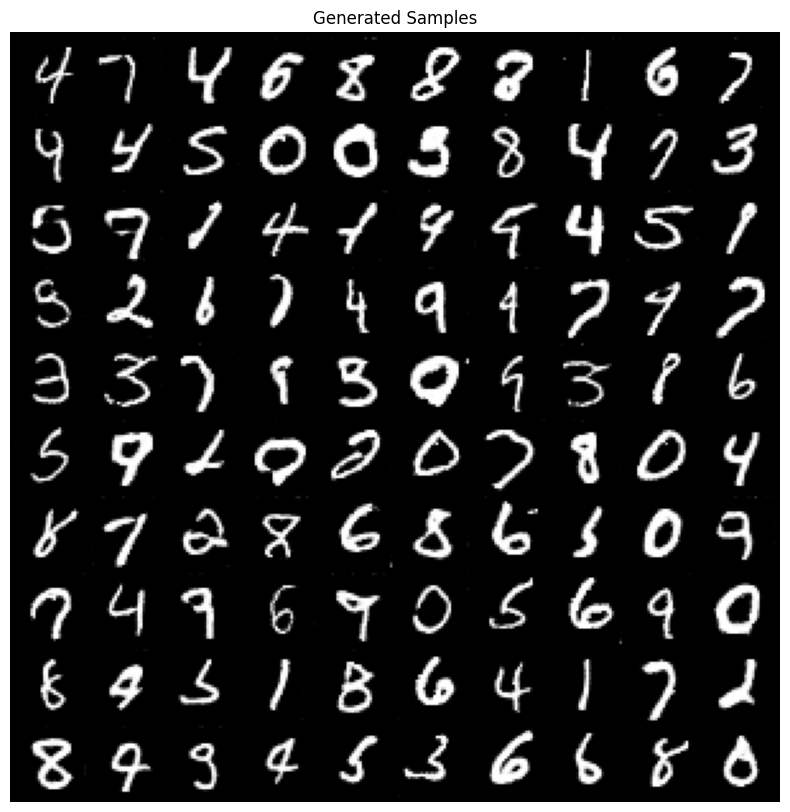

In [6]:
import matplotlib.pyplot as plt
import torchvision

# Generate 100 samples
fixed_noise_z = torch.randn(100, Z_DIM, 1, 1).to(device)
gen.eval()  # Switch generator to evaluation mode
with torch.no_grad():
    generated_images = gen(fixed_noise_z)  # Generate fake images

# Normalize and create grid
generated_images = generated_images * 0.5 + 0.5  # Rescale to [0, 1] for visualization
grid = torchvision.utils.make_grid(generated_images, nrow=10, normalize=True)

# Plot the grid
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())  # Convert to HWC format for plotting
plt.axis("off")
plt.title("Generated Samples")
plt.show()


In [9]:
from google.colab import drive
drive.mount('/content/drive')

# Save to Google Drive
torch.save(gen.state_dict(), "/content/drive/MyDrive/generator.pth")
torch.save(disc.state_dict(), "/content/drive/MyDrive/discriminator.pth")


Mounted at /content/drive


### Part 5: GAN Inversion
In this part, we aim to find the latent vectors corresponding to the samples in the dataset. First, select a random sample from the real dataset and a random latent vector. Freeze the generator and feed the random latent vector into the Generator. Next, define an MSE or MAE loss between the generated sample and the real sample, and optimize the random latent vector to discover the latent vector that generates the selected real sample.


Iteration [0/500], Loss: 1.281146
Iteration [50/500], Loss: 0.888477
Iteration [100/500], Loss: 0.761951
Iteration [150/500], Loss: 0.736661
Iteration [200/500], Loss: 0.721411
Iteration [250/500], Loss: 0.714144
Iteration [300/500], Loss: 0.710530
Iteration [350/500], Loss: 0.706336
Iteration [400/500], Loss: 0.686723
Iteration [450/500], Loss: 0.683256


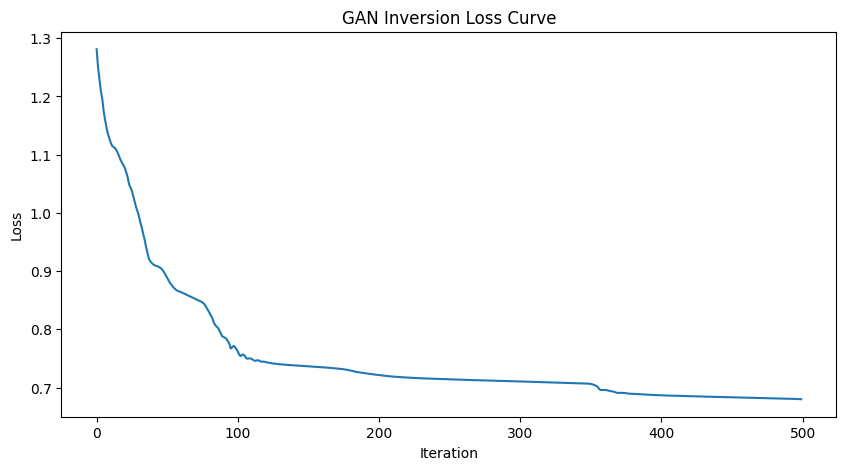

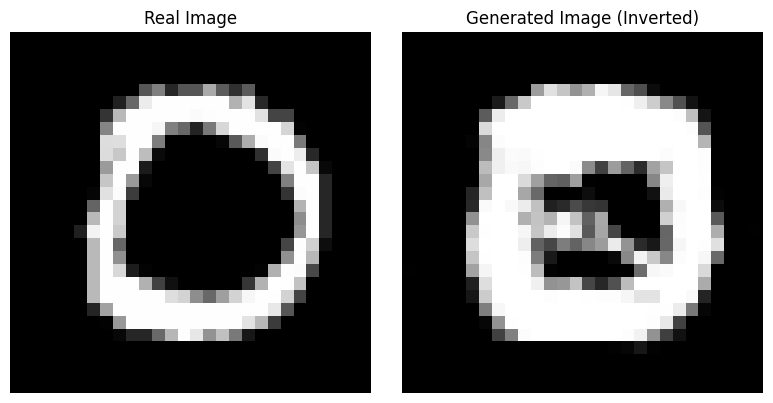

In [7]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Select a random real sample from the dataset
real_sample, _ = next(iter(dataloader))  # Get a batch of real images
real_image = real_sample[0:1].to(device)  # Select one image and move to device
real_image = real_image * 0.5 + 0.5  # Normalize for visualization if necessary

# Initialize a random latent vector
z = torch.randn(1, Z_DIM, 1, 1, device=device, requires_grad=True)

# Freeze generator weights
gen.eval()
for param in gen.parameters():
    param.requires_grad = False

# Define optimizer and loss function
optimizer = torch.optim.Adam([z], lr=1e-2)  # Only optimize z
criterion = nn.MSELoss()

# Perform optimization
num_iterations = 500
losses = []

for iteration in range(num_iterations):
    optimizer.zero_grad()

    # Generate an image using the current z
    generated_image = gen(z)

    # Compute loss between generated and real image
    loss = criterion(generated_image, real_image)
    losses.append(loss.item())

    # Backpropagate and update z
    loss.backward()
    optimizer.step()

    # Optionally, clamp z to stay within a reasonable range
    z.data.clamp_(-2, 2)

    # Print progress
    if iteration % 50 == 0:
        print(f"Iteration [{iteration}/{num_iterations}], Loss: {loss.item():.6f}")

# Plot the loss curve
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("GAN Inversion Loss Curve")
plt.show()

# Visualize the results
with torch.no_grad():
    generated_image = gen(z)
    generated_image = generated_image * 0.5 + 0.5  # Rescale to [0, 1]

# Plot the real and generated images
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(real_image[0].permute(1, 2, 0).cpu().numpy(), cmap="gray")
axs[0].axis("off")
axs[0].set_title("Real Image")

axs[1].imshow(generated_image[0].permute(1, 2, 0).cpu().numpy(), cmap="gray")
axs[1].axis("off")
axs[1].set_title("Generated Image (Inverted)")
plt.tight_layout()
plt.show()


### Part 6: Interpolating the Latent Space
In this part, you will interpolate the latent space using a 10 by 10 grid. Start with 4 initial points representing the corners of the square, and then perform linear or spherical interpolation between the latent vectors of these 4 images to fill the circumference of the square.
Next, fill in the rest of the square by interpolating between the latent vectors along the circumference.

If $G$ is the generator, and $z_1$ and $z_2$ are two latent vectors of two images, let $w$ be a parameter that varies between $0$ and $1$. The linearly interpolated sample is generated as:

\begin{equation}
G(w \cdot z_1 + (1 - w) \cdot z_2)\
\end{equation}

Try to select the 4 starting images from those that exhibit distinct features. For example, the two top right corners could be the same digit but one with a thick stroke and the other with a thin stroke, while the other two points should be from a different digit but with varying stroke styles.

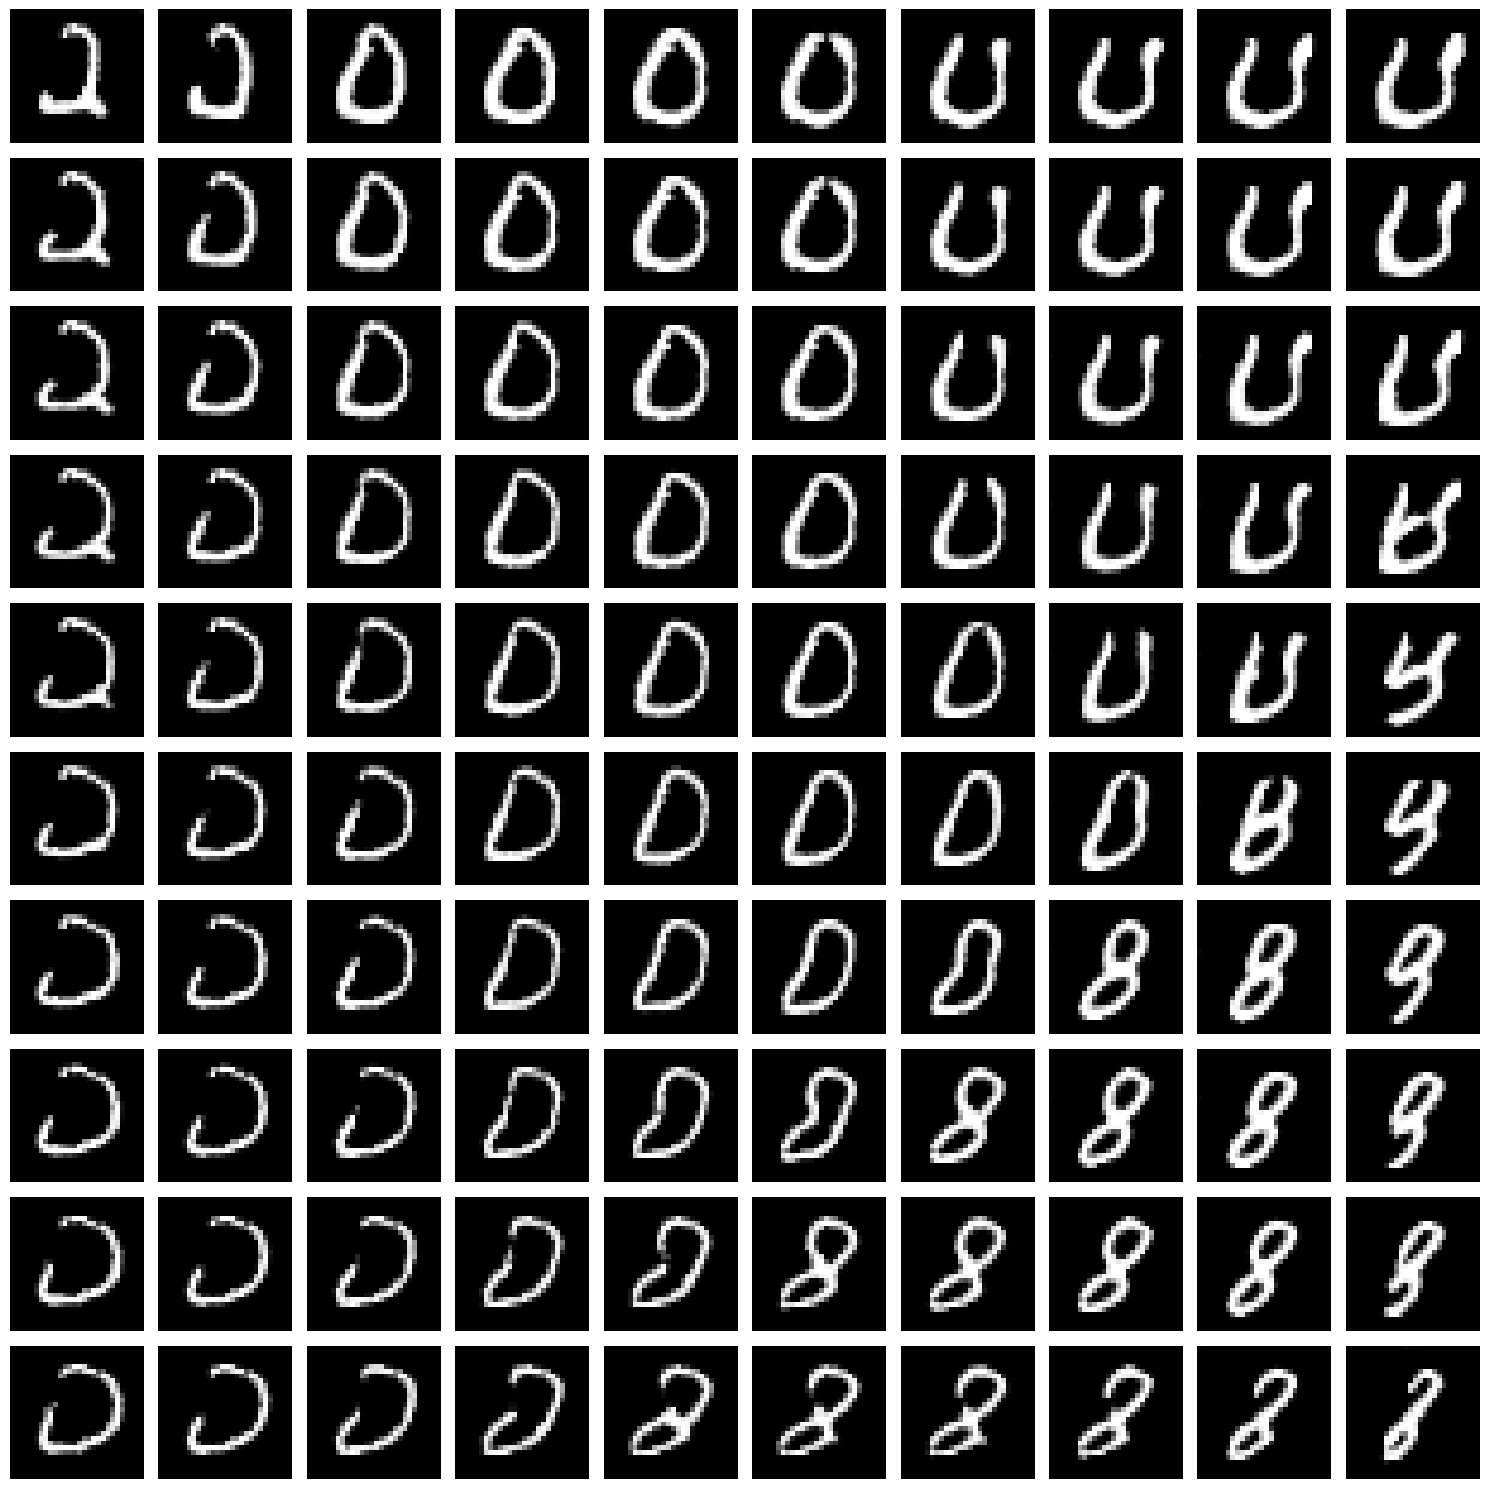

In [10]:
# Generate 4 distinct latent points
z1 = torch.randn(1, Z_DIM, 1, 1).to(device)  # Top-left
z2 = torch.randn(1, Z_DIM, 1, 1).to(device)  # Top-right
z3 = torch.randn(1, Z_DIM, 1, 1).to(device)  # Bottom-left
z4 = torch.randn(1, Z_DIM, 1, 1).to(device)  # Bottom-right

def slerp(val, low, high):
    omega = torch.arccos(torch.dot(low / torch.norm(low), high / torch.norm(high)))
    so = torch.sin(omega)
    if so == 0:
        return (1.0 - val) * low + val * high  # Linear interpolation for collinear vectors
    return torch.sin((1.0 - val) * omega) / so * low + torch.sin(val * omega) / so * high

def interpolate_points(z_start, z_end, num_steps=10, spherical=False):
    interpolated = []
    for i in range(num_steps):
        w = i / (num_steps - 1)  # Interpolation factor (0 to 1)
        if spherical:
            z_interp = slerp(w, z_start.flatten(), z_end.flatten())
        else:
            z_interp = w * z_start + (1 - w) * z_end
        interpolated.append(z_interp)
    return interpolated

top_edge = interpolate_points(z1, z2, spherical=True)
right_edge = interpolate_points(z2, z4, spherical=True)
bottom_edge = interpolate_points(z3, z4, spherical=True)
left_edge = interpolate_points(z1, z3, spherical=True)

grid = []
for i in range(10):  # Along rows
    row_start = top_edge[i]
    row_end = bottom_edge[i]
    grid.append(interpolate_points(row_start, row_end, spherical=True))

import matplotlib.pyplot as plt

# Convert grid of latent vectors to grid of images
grid_images = []
for row in grid:
    row_images = [gen(latent.view(1, Z_DIM, 1, 1)).squeeze().detach().cpu().numpy() for latent in row]
    grid_images.append(row_images)

# Plot the grid
fig, axes = plt.subplots(10, 10, figsize=(15, 15))
for i, row in enumerate(grid_images):
    for j, img in enumerate(row):
        axes[i, j].imshow(img, cmap="gray")
        axes[i, j].axis("off")
plt.tight_layout()
plt.show()



### Part 7: Arithmetic Operation in Latent Space
In this part, you will attempt to modify the thickness or thinness of a sample by identifying the direction in the latent space that corresponds to these attributes. Additionally, you can explore changing a digit to another (e.g., transforming a digit into a 3) by finding the direction in the latent space that corresponds to that digit.


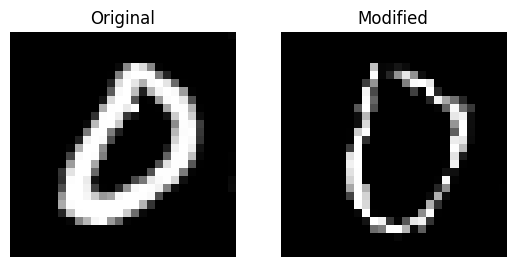

In [15]:
z_thick = torch.randn(1, Z_DIM, 1, 1).to(device)  # A latent vector generating a thick digit
z_thin = torch.randn(1, Z_DIM, 1, 1).to(device)   # A latent vector generating a thin digit

direction_thickness = z_thick - z_thin
def modify_latent(z_base, direction, alpha=1.0):
    return z_base + alpha * direction

z_base = torch.randn(1, Z_DIM, 1, 1).to(device)
modified_latent = modify_latent(z_base, direction_thickness, alpha=2.0)
original_image = gen(z_base).squeeze().detach().cpu().numpy()
modified_image = gen(modified_latent).squeeze().detach().cpu().numpy()

# Plot the original and modified images
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(modified_image, cmap="gray")
plt.title("Modified")
plt.axis("off")

plt.show()



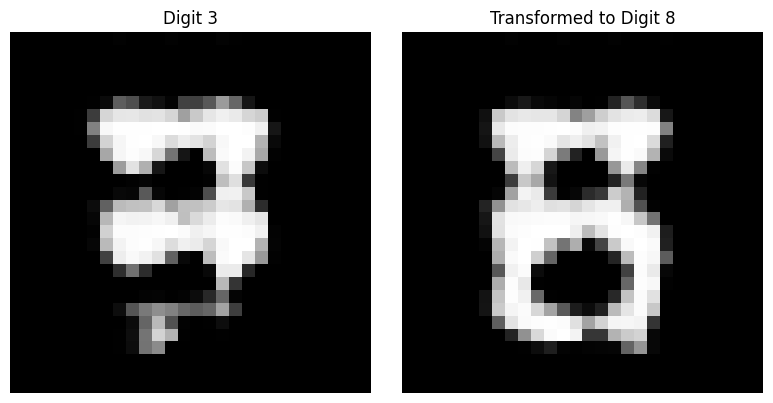

In [46]:
# Import necessary libraries
import torch
import matplotlib.pyplot as plt

# Function to modify a latent vector by adding a direction
def modify_latent(z_base, direction, alpha=1.0):
    """
    Modifies a latent vector by adding a scaled direction vector.

    Parameters:
    - z_base: torch.Tensor, the base latent vector.
    - direction: torch.Tensor, the direction vector for modification.
    - alpha: float, the scaling factor for the direction.

    Returns:
    - torch.Tensor, the modified latent vector.
    """
    return z_base + alpha * direction


# Generate latent vectors for "digit 3" and "digit 8"
z_digit3 = torch.randn(1, Z_DIM, 1, 1, device=device)  # A latent vector generating "3"
z_digit8 = torch.randn(1, Z_DIM, 1, 1, device=device)  # A latent vector generating "8"

# Generate latent vectors for specific digits or attributes (e.g., from labeled data)
latent_vectors_for_digit3 = [torch.randn(1, Z_DIM, 1, 1, device=device) for _ in range(10)]
latent_vectors_for_digit8 = [torch.randn(1, Z_DIM, 1, 1, device=device) for _ in range(10)]

# Compute mean latent vectors for "digit 3" and "digit 8"
mean_latent_digit3 = torch.mean(torch.stack(latent_vectors_for_digit3), dim=0).to(device)
mean_latent_digit8 = torch.mean(torch.stack(latent_vectors_for_digit8), dim=0).to(device)

# Compute the direction for transforming "3" to "8"
direction_digit3_to_digit8 = mean_latent_digit8 - mean_latent_digit3

# Base latent vector (corresponding to a "3")
z_base = mean_latent_digit3

# Transform the latent vector in the direction of "8"
alpha = 1.0  # Adjust the scaling factor as needed
transformed_latent = modify_latent(z_base, direction_digit3_to_digit8, alpha=alpha)

# Generate the original and transformed images
original_image = gen(z_base).squeeze().detach().cpu().numpy()
transformed_image = gen(transformed_latent).squeeze().detach().cpu().numpy()

# Plot the original and transformed images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap="gray")
plt.title("Digit 3")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(transformed_image, cmap="gray")
plt.title("Transformed to Digit 8")
plt.axis("off")

plt.tight_layout()
plt.show()
